## PyMC3 example

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import sys
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)

Python version: 3.7.7 (default, Mar 23 2020, 23:19:08) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.18.1
PyMC3 version: 3.8


In [3]:
df = pd.read_csv("intervals.csv")

In [4]:
df.head()

,EL,ER,SL,SR
0,0,45.999306,49.0,49.999306
1,14,43.999306,44.0,54.999306
2,39,49.375000,53.0,53.500000
3,0,35.999306,35.0,35.999306
4,0,43.999306,0.0,43.999306


![](reich_figure_1.png)

Figure 1 from Reich et al. (2009), _Estimating incubation period distributions with coarse data_. 

In [5]:
Tmin = np.array(np.maximum(df["SL"]-df["ER"], 0))
Tmax = np.array(df["SR"]-df["EL"])

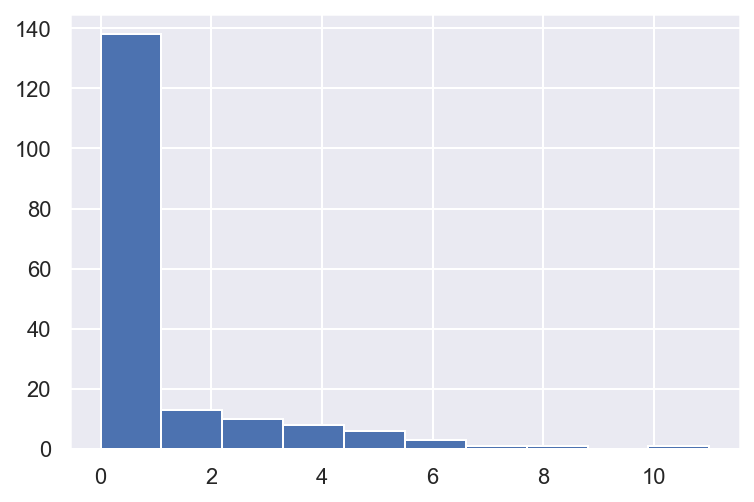

In [6]:
plt.hist(Tmin);

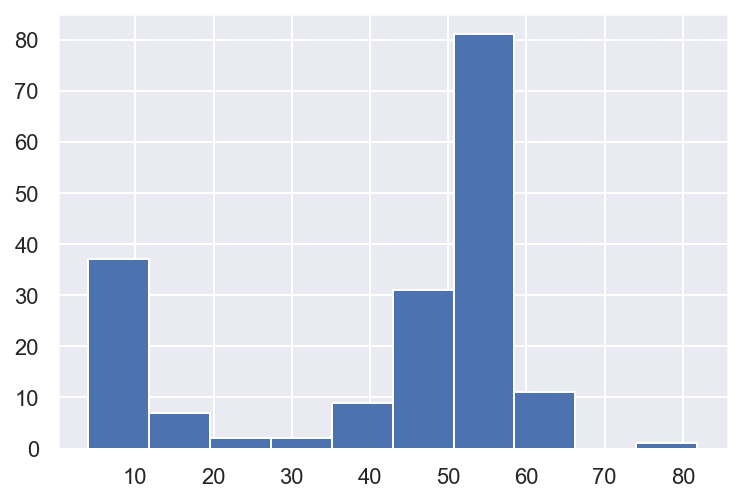

In [7]:
plt.hist(Tmax);

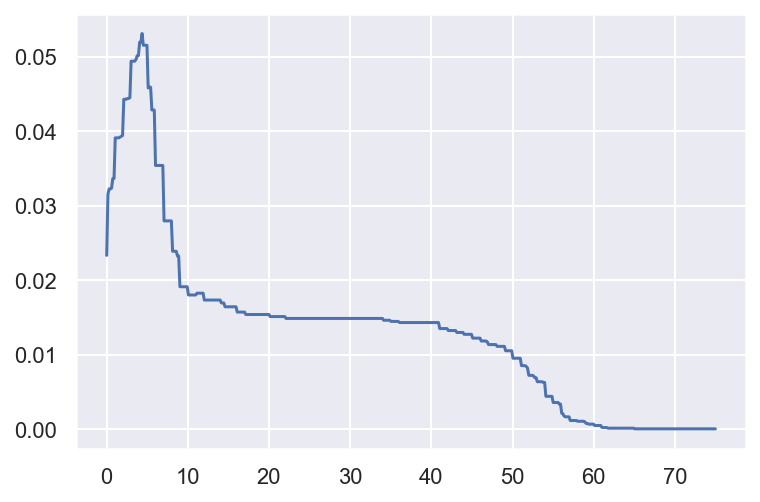

In [8]:
xs = np.linspace(0, 75, 500)
ys = np.zeros(len(xs))

nCases = len(Tmin)
for i in range(nCases):
    ys[(xs >= Tmin[i]) & (xs <= Tmax[i])] += 1 / (nCases * (Tmax[i]-Tmin[i]))
    
plt.plot(xs, ys);

In [9]:
Tavgs = (Tmin + Tmax) / 2

In [10]:
%%time
with pm.Model() as model:
    μ = pm.Uniform('μ', lower=-25, upper=25)
    σ = pm.Uniform('σ', lower=0, upper=25) 
    T = pm.Lognormal('T', mu=μ, sigma=σ, observed=Tavgs)
    trace = pm.sample(10**4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████████████████████████| 42000/42000 [00:19<00:00, 2124.38draws/s]


Wall time: 53 s


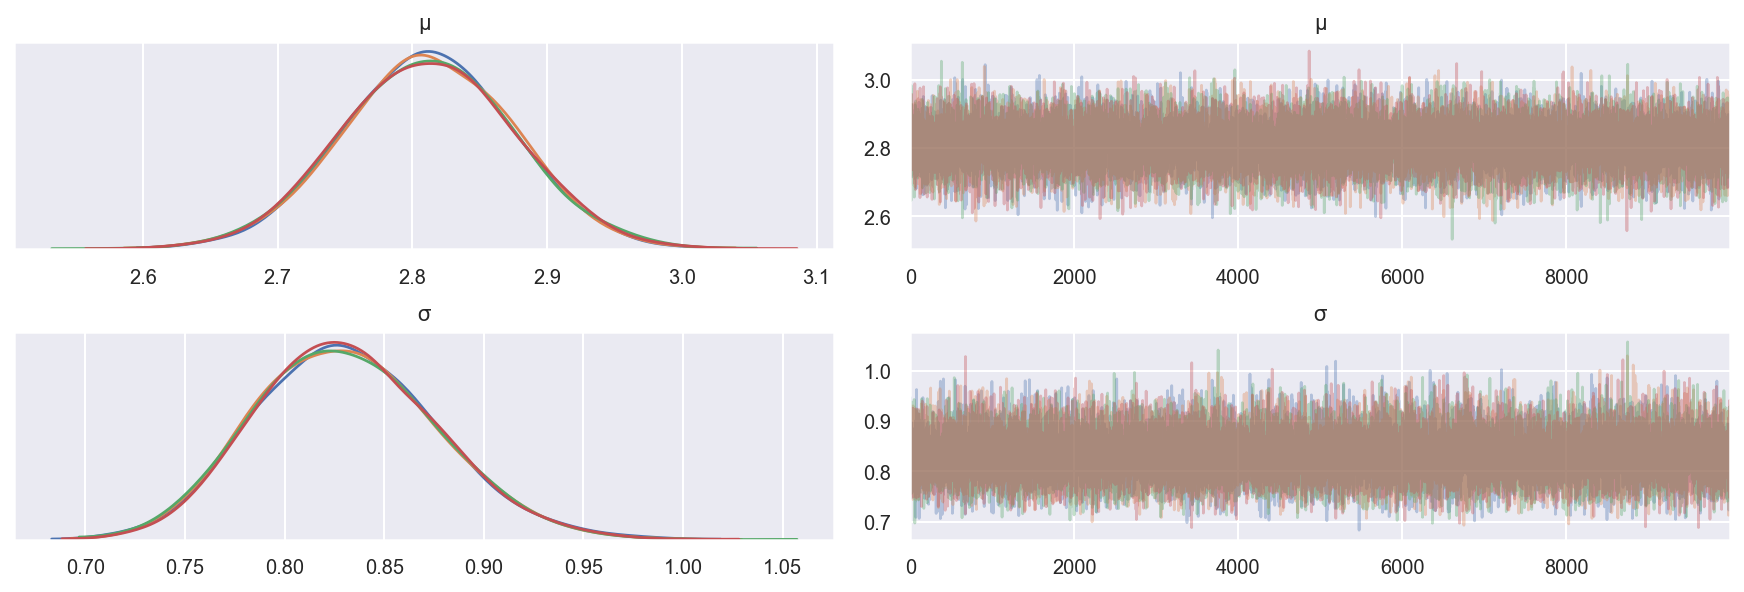

In [11]:
pm.plot_trace(trace);

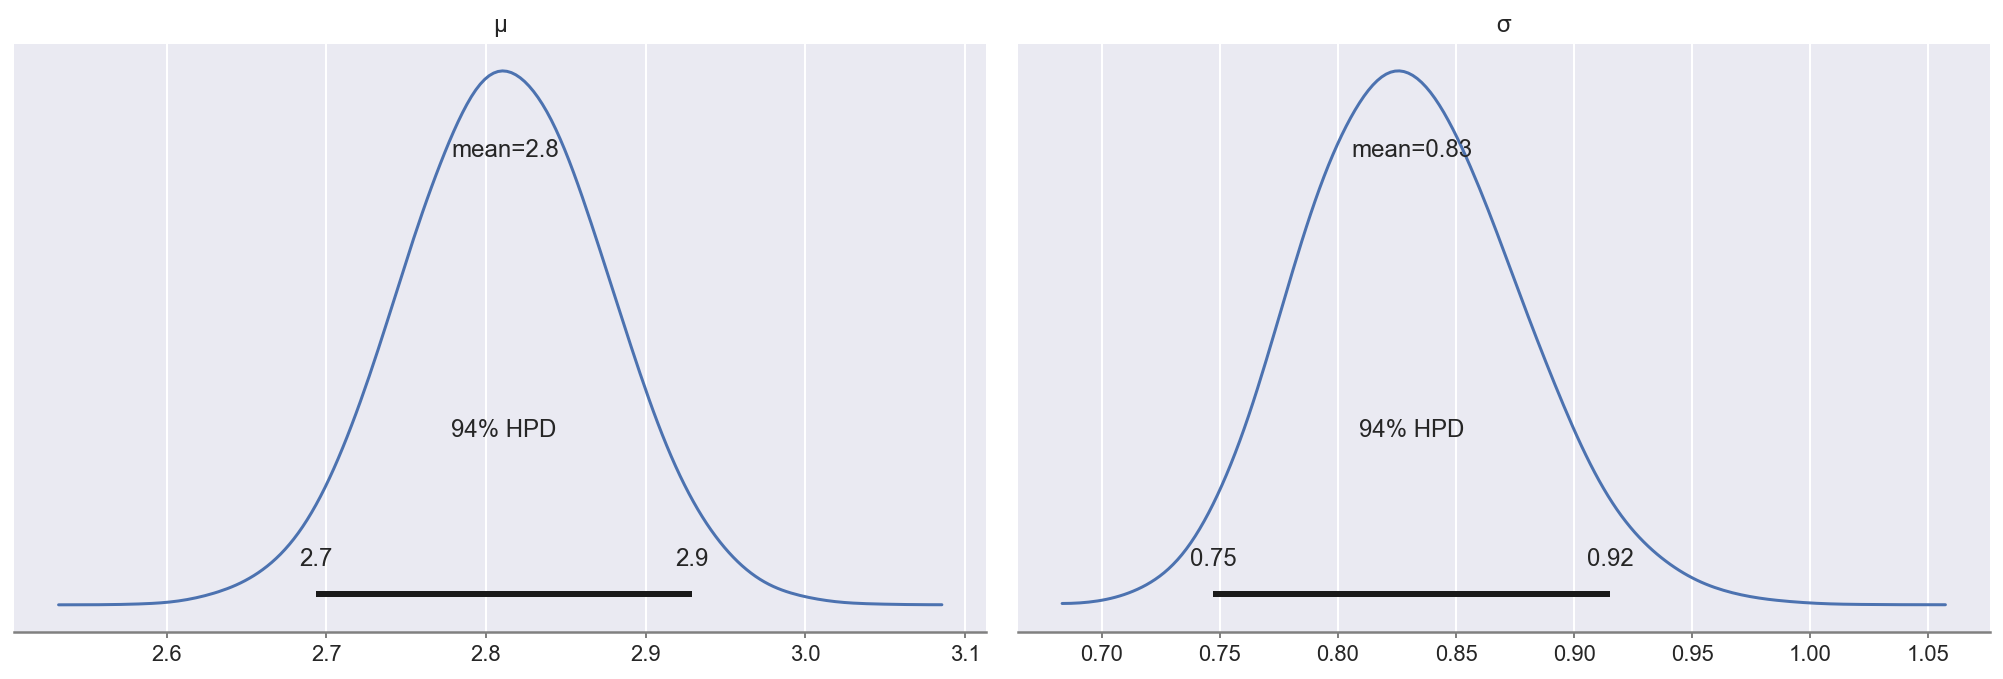

In [12]:
pm.plot_posterior(trace);

This is assuming we have observations $\boldsymbol{T} = (T_1, \dots, T_n)$ which gives us a likelihood of

$$ L(\mu, \sigma \mid \boldsymbol{T}) = \prod_{i=1}^n f(T_i; \mu, \sigma )  $$

where $f(x; \mu, \sigma)$ is the p.d.f. of the $\mathsf{LogNormal}(\mu, \sigma^2)$ distribution.

However we don't have observations, just intervals. Say each unobserved period fell into $T_i \in [T_i^-, T_i^+]$. Our likelihood becomes

$$ L(\mu, \sigma \mid \boldsymbol{T}^{\,-}, \boldsymbol{T}^{\,+}) = \prod_{i=1}^n \bigl[ F(T_i^+ ; \mu, \sigma) - F(T_i^-; \mu, \sigma) \bigr] $$

where $F(x; \mu, \sigma)$ is the c.d.f. of the $\mathsf{LogNormal}(\mu, \sigma^2)$ distribution.

In [13]:
import theano.tensor as tt

# Taken from PyMC3's pymc3/distributions/dist_math.py file
# starting at line 346.
def zvalue(x, sigma, mu):
    """
    Calculate the z-value for a normal distribution.
    """
    return (x - mu) / sigma

# Taken from PyMC3's pymc3/distributions/continuous.py file
# starting at line 1849.
def cdf(x, mu, sigma):
        """
        Compute the log of the cumulative distribution function for Lognormal distribution
        at the specified value.

        Parameters
        ----------
        x: numeric
            Value(s) for which log CDF is calculated. If the log CDF for multiple
            values are desired the values must be provided in a numpy array or theano tensor.

        Returns
        -------
        TensorVariable
        """
        z = zvalue(np.log(x), mu=mu, sigma=sigma)

        return tt.switch(
                tt.lt(z, -1.0),
                tt.erfcx(-z / tt.sqrt(2.)) / 2. * np.exp(-tt.sqr(z) / 2),
                tt.erfc(-z / tt.sqrt(2.)) / 2.
        )

With `Potential` we have to add log-terms to the likelihood. So


$$ \log \bigl[ L(\mu, \sigma \mid \boldsymbol{T}^{\,-}, \boldsymbol{T}^{\,+}) \bigr] = \sum_{i=1}^n \log \bigl[  F(T_i^+ ; \mu, \sigma) - F(T_i^-; \mu, \sigma) \bigr] \,. $$


In [14]:
%%time
with pm.Model() as model:
    μ = pm.Uniform('μ', lower=-25, upper=25)
    σ = pm.Uniform('σ', lower=0, upper=25) 
    pm.Potential('T', tt.sum(tt.log( cdf(Tmax, μ, σ) - cdf(Tmin, μ, σ) )))
    trace = pm.sample(10**5, step=pm.Metropolis()) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [σ]
>Metropolis: [μ]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████████████████████| 402000/402000 [03:16<00:00, 2040.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


Wall time: 3min 41s


In [15]:
pm.stats.ess(trace["μ"]), pm.stats.ess(trace["σ"]) 

(30595.937405029406, 55537.902861184826)

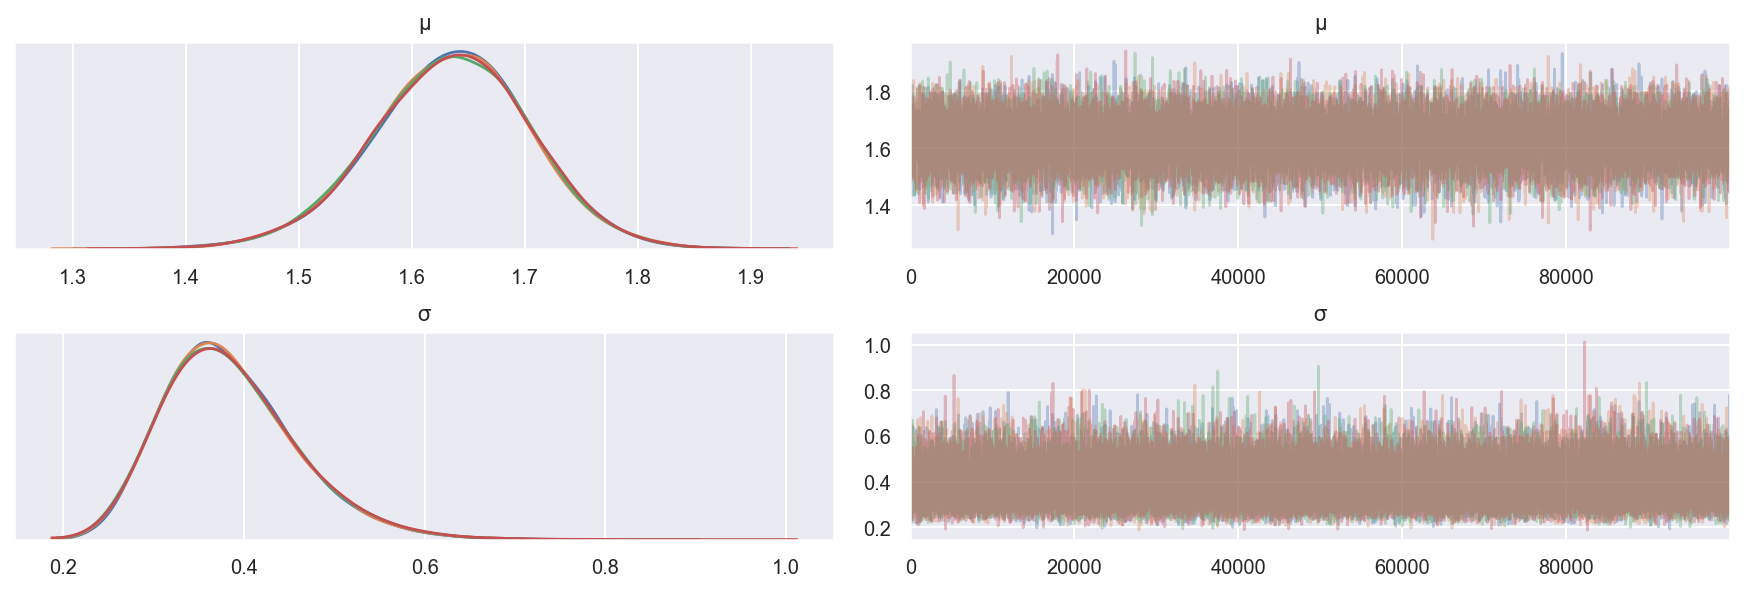

In [16]:
pm.plot_trace(trace);

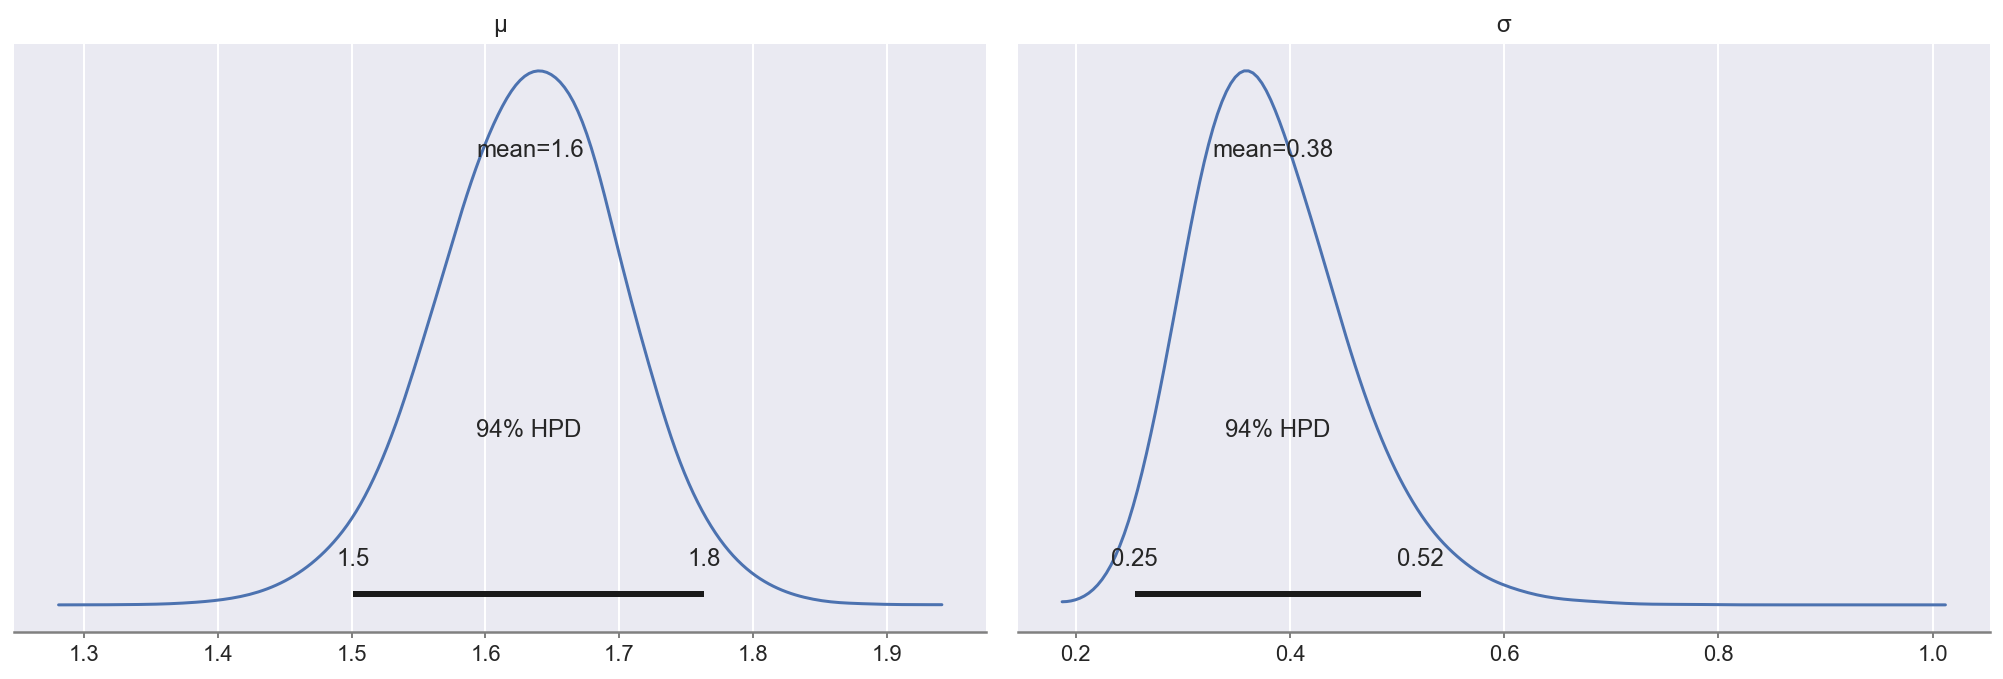

In [17]:
pm.plot_posterior(trace);

In [18]:
trace["μ"].mean()

1.6333400315715902

In [19]:
trace["σ"].mean()

0.3841109415517976